In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(12,7)})

In [2]:
import sqlalchemy
import pandas as pd
import os
import datetime
from tqdm.notebook import tqdm as tqdm_notebook
#import mmh3
import seaborn as sns

from sqlalchemy import create_engine

from clickhouse_sqlalchemy import make_session
from urllib.parse import quote

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

import pandahouse

In [9]:
!pip install pandahouse

Defaulting to user installation because normal site-packages is not writeable


In [3]:
password = 'dimVuidBun1onCub'
login = 'a.al.kosheleva'

def postre_auth(login, password):
    postgresql_config = {
    'postgresql_prefix' : 'postgresql'
    , 'postgresql_host'   : '10.3.26.92' 
    , 'postgresql_user'   : f'{login}'
    , 'postgresql_pass'   : f'{password}'
    , 'postgresql_port'   : '5432'
    , 'postgresql_db'     : 'dwh'    
    }

    postgresql_connection_string  = "{prefix}://{user}:{passw}@{host}:{port}/{db}".format(
    prefix  =   postgresql_config['postgresql_prefix']    , host  =   postgresql_config['postgresql_host']
    , user  =   postgresql_config['postgresql_user']      , passw =   postgresql_config['postgresql_pass']
    , port  =   postgresql_config['postgresql_port']      , db    =   postgresql_config['postgresql_db']
    )
    postgresql_engine = sqlalchemy.create_engine(postgresql_connection_string)
    postgresql_conn   = postgresql_engine.connect()
    return postgresql_engine, postgresql_conn

postrgre_engine, postrge_conn = postre_auth(login, password)

In [4]:
connection_kh = {
            'host': 'http://clickhouse-02.lenta.tech:8123',
            'password': 'Gnjrw1HhkByi',
            'user': 'a_al_kosheleva',
            'database':'dwh_stage'
            }

In [5]:
#берем вчерашнюю дату и дату N дней назад, в нашем случае 90
from datetime import datetime, timedelta
yesterday = datetime.now() - timedelta(1)
three_months_ago = datetime.now() - timedelta(91)

first_date = datetime.strftime(three_months_ago, '%Y-%m-%d')
last_date = datetime.strftime(yesterday, '%Y-%m-%d')

In [6]:
#выгружаем активных юзеров из bq за определенный день, за вчера
sql = f'''SELECT distinct user_id 
FROM dwh_datamart.daily_aud_aggregate_app
WHERE event_date = '{last_date}' and any_active > 0
and user_id is not null and user_id != 'null'
'''
buyers = pandahouse.read_clickhouse(sql, connection=connection_kh)

ConnectionError: HTTPConnectionPool(host='clickhouse-02.lenta.tech', port=8123): Max retries exceeded with url: /?query=SELECT+distinct+user_id+%0AFROM+dwh_datamart.daily_aud_aggregate_app%0AWHERE+event_date+%3D+%272023-07-10%27+and+any_active+%3E+0%0Aand+user_id+is+not+null+and+user_id+%21%3D+%27null%27+FORMAT+TSVWithNamesAndTypes&user=a_al_kosheleva&password=Gnjrw1HhkByi (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7ff45866cdd8>: Failed to establish a new connection: [Errno 110] Connection timed out',))

In [282]:
buyers_list = tuple(buyers.user_id.to_list())

In [7]:
new_users = f'''
select distinct buyer_id
from dwh_datamart.retention
where date(first_order) between date('{last_date}' - INTERVAL '30 day') and '{last_date}'
and buyer_id IN {buyers_list}
'''

NameError: name 'buyers_list' is not defined

In [8]:
old_users_list = pd.read_sql(old_users, postrge_conn)

NameError: name 'old_users' is not defined

In [285]:
buyers_list_fin = old_users_list.buyer_id.to_list()

In [286]:
#выгрузка текущая - для людей, зашедших 18 апреля
financial_data = f'''
with
orders AS (
select distinct buyer_id, pav_order_id, order_type, bill_amount
from dwh_datamart.ops_metrics
where date(created) between '2023-01-18' AND '2023-04-18'
and flag_cancel = 0 and order_source IN ('iOS', 'Android')
),

pcodes AS (
select distinct pav_order_id, action_id
from dwh_stage.utk_sess_utk_promocode_buyer_using
where date(created) between '2023-01-18' AND '2023-04-18'
),

orders_with_pcodes AS (
select buyer_id, o.pav_order_id, bill_amount,
       case when action_id is null then  0 else 1 end as pcode,
       case when order_type = 'Быстро' then 1 else 0 end as is_express
from orders o left join pcodes p on o.pav_order_id = p.pav_order_id
)

select buyer_id,
sum(bill_amount)/count(distinct pav_order_id) as avg_check,
sum(bill_amount) as revenue,
count(distinct pav_order_id) as frequency, round(sum(pcode)*1.00/count(distinct pav_order_id),2) as pcode_orders_percent,
round(sum(is_express)*1.00/count(distinct pav_order_id),2) as express_orders_percent
from orders_with_pcodes
group by 1;
'''

In [288]:
#выгрузка делалась 31 марта 2023 - нужно ставить в  orders >= date(date(now()) - INTERVAL '3 month')
categories_data = f'''
with cats AS (
select
  substr(mat.material,13,18)  original_id,
  wgh._0rpa_wgh2___t          cat_name
from dwh_stage.hadoop_bi0_pmaterial mat
inner join dwh_stage.hadoop_bic_rpa_wgh wgh
on mat.rpa_wgh4 = wgh._0rpa_wgh4
where rpa_wgh2 != '99'
and wgh._0rpa_wgh2___t != 'Резервная группа'
group by 1,2),

orders AS (
select distinct buyer_id, pav_order_id
from dwh_datamart.ops_metrics
where date(created) between '2023-01-18' AND '2023-04-18'
and flag_cancel = 0 and order_source IN ('iOS', 'Android')
),

t1 as (
select
  buyer_id,
  cat_name,
  count_courier*zit.denominator/zit.numerator as number,
  sum(count_courier*zit.denominator/zit.numerator) over (partition by buyer_id) as count_items_total
from orders z
inner join dwh_stage.utk_sess_zakaz_items zit
on zit.pav_order_id = z.pav_order_id
left join cats c on zit.original_id = c.original_id
where zit.numerator != 0
)


select buyer_id, cat_name, sum(number)*1.00/max(count_items_total) percent_cat
from t1
where count_items_total > 0
group by 1,2
'''



In [289]:
financial_df = pd.read_sql(financial_data, postrge_conn)

In [290]:
financial_df

,buyer_id,avg_check,revenue,frequency,pcode_orders_percent,express_orders_percent
0,94025409,2358.855000,4717.71,2,1.0,0.00
1,94115028,2646.743333,7940.23,3,0.0,0.33
2,94578440,2057.930000,8231.72,4,1.0,0.00
3,94578442,2080.885000,4161.77,2,1.0,0.00
4,94578475,3205.426000,64108.52,20,1.0,0.20
...,...,...,...,...,...,...
719095,105275886,1075.840000,1075.84,1,1.0,0.00
719096,105275903,810.160000,810.16,1,0.0,0.00
719097,105275923,2226.170000,2226.17,1,1.0,0.00
719098,105275926,1406.370000,1406.37,1,1.0,0.00


In [291]:
categories_df = pd.read_sql(categories_data, postrge_conn)

In [292]:
categories_df

,buyer_id,cat_name,percent_cat
0,94605516,П\ф и другие продукты глубокой заморзк,0.067081
1,94606002,Средства персонального ухода,0.010011
2,94588448,Фрукты,0.138104
3,94583735,Традиционная молочная продукция,0.088014
4,94608174,Детское питание,0.052210
...,...,...,...
8587772,99030273,Средства персонального ухода,0.006883
8587773,98586613,Сыры,0.095140
8587774,96034521,Традиционная молочная продукция,0.102130
8587775,98944124,Консервы,0.040228


In [293]:
financial_df = pd.DataFrame(financial_df.query("buyer_id == @buyers_list_fin"))

In [294]:
categories_df = pd.DataFrame(categories_df.query("buyer_id == @buyers_list_fin"))

In [295]:
categories_df_pivot = pd.pivot_table(categories_df, values='percent_cat', index=['buyer_id'],
                    columns=['cat_name'], aggfunc=np.sum).reset_index()

In [296]:
categories_df_pivot

cat_name,buyer_id,Автотовары,Аксессуары и галантерея,"Аудио, видео, цифровая техника и аксессу",Багаж,Бакалея,Безалкогольные напитки,Бытовая техника,"Бытовая химия, хозяйственные товары",Вино,...,Товары для сада,Товары для уборки и хранения,Товары к Новому году,Товары сделай сам (DIY),Традиционная молочная продукция,Фрукты,Функциональное питание,Шоколадные кондитерские изделия,Электротовары,Яйцо
0,94578475,NaN,NaN,NaN,NaN,0.033816,0.004411,NaN,0.017643,NaN,...,NaN,0.013233,NaN,NaN,0.032346,0.127577,0.001470,0.052930,NaN,0.019114
1,94578497,NaN,NaN,NaN,NaN,0.066916,0.037822,NaN,0.023275,NaN,...,NaN,NaN,NaN,NaN,0.074189,0.065765,0.007273,0.048226,NaN,0.016002
2,94578644,NaN,NaN,NaN,NaN,0.033348,0.233437,NaN,0.011116,NaN,...,NaN,NaN,NaN,NaN,0.041685,0.057889,NaN,NaN,NaN,0.008337
3,94578658,NaN,NaN,NaN,NaN,0.069291,0.265615,NaN,0.046194,NaN,...,NaN,NaN,NaN,NaN,0.103936,0.046564,NaN,0.023097,NaN,NaN
4,94578760,NaN,NaN,NaN,NaN,0.044556,0.089112,NaN,0.019803,NaN,...,NaN,0.002475,NaN,NaN,0.061884,0.119789,NaN,0.012377,NaN,0.002475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71537,103966137,NaN,NaN,NaN,NaN,0.360866,NaN,NaN,0.040096,NaN,...,NaN,0.080192,NaN,NaN,0.120289,NaN,NaN,NaN,NaN,0.040096
71538,103966682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71539,103966776,NaN,NaN,NaN,NaN,0.058179,0.098905,NaN,0.029090,NaN,...,NaN,0.005818,NaN,NaN,0.075633,0.014405,0.005818,0.029090,NaN,NaN
71540,103967206,NaN,NaN,NaN,NaN,NaN,0.032559,NaN,0.065117,NaN,...,NaN,NaN,NaN,NaN,NaN,0.837206,NaN,NaN,NaN,NaN


In [297]:
categories_df_pivot.buyer_id.nunique()

71542

In [298]:
financial_df.buyer_id.nunique()

71549

In [299]:
final_df = categories_df_pivot.merge(financial_df, on = 'buyer_id', how = 'inner')

In [300]:
final_df = final_df.fillna(0)

In [301]:
final_df_sample = final_df.sample(n=30000, random_state=1)

In [302]:
final_df_sample.reset_index(drop= True , inplace= True)

In [303]:
#final_df_sample.to_excel('final_df_sample.xlsx')

In [304]:
column_headers = list(final_df_sample.columns.values)

In [305]:
# преобразуем датафрейм для кластеризации (убираем тяжелые хвосты в метриках)
def get_log_df(data):
    def log_transform(v): 
        res = np.log(v+1)
        return res
    
    data_tmp = data.copy()
    for el in ['Автотовары',
 'Аксессуары и галантерея',
 'Аудио, видео, цифровая техника и аксессу',
 'Багаж',
 'Бакалея',
 'Безалкогольные напитки',
 'Бытовая техника',
 'Бытовая химия, хозяйственные товары',
 'Вино',
 'Гигиенические средства',
 'Деликатесы из рыбы и морепродуктов',
 'Детская гигиена',
 'Детская одежда, обувь и постельные прин',
 'Детское питание',
 'Женская и мужская одежда',
 'Женское и мужское нижнее белье',
 'Живые горшечные цветы, срезка',
 'Закуски к аперитивам',
 'Замороженная рыба',
 'Игрушки',
 'Канцелярия и печатная продукция',
 'Консервы',
 'Косметика и аксессуары',
 'Кофе, какао, чай',
 'Кулинария собственного производства',
 'Майонезы, Закуски, Готовые Блюда охл',
 'Масложировая продукция',
 'Молочные продукты д/детского питания',
 'Морепродукты глубокой заморозки',
 'Мясо глубокой заморозки',
 'Мясо охлажденное',
 'Не шоколадные кондитерские изделия',
 'Овощи',
 'Одежда и товары для новорождённых',
 'Охлажденная и переработанная рыбная прод',
 'П\\ф и другие продукты глубокой заморзк',
 'Пекарня промышленное производство',
 'Пекарня собственное производство',
 'Пиво и слабоалкогольные напитки',
 'Посуда столовая, товары для дома',
 'Продукты мясной переработки',
 'Профессиональные Товары для животных',
 'Птица глубокой заморозки',
 'Птица охлажденная',
 'Современная молочная продукция',
 'Спорт, туризм',
 'Средства персонального ухода',
 'Сыры',
 'Табачные изделия',
 'Текстиль для дома',
 'Товары для акции лояльности КС',
 'Товары для животных',
 'Товары для приготовления',
 'Товары для сада',
 'Товары для уборки и хранения',
 'Товары сделай сам (DIY)',
 'Традиционная молочная продукция',
 'Фрукты',
 'Функциональное питание',
 'Шоколадные кондитерские изделия',
 'Электротовары',
 'Яйцо']:
        data_tmp[el] = data_tmp[el].apply(lambda x: log_transform(x))
    return data_tmp[['Автотовары',
 'Аксессуары и галантерея',
 'Аудио, видео, цифровая техника и аксессу',
 'Багаж',
 'Бакалея',
 'Безалкогольные напитки',
 'Бытовая техника',
 'Бытовая химия, хозяйственные товары',
 'Вино',
 'Гигиенические средства',
 'Деликатесы из рыбы и морепродуктов',
 'Детская гигиена',
 'Детская одежда, обувь и постельные прин',
 'Детское питание',
 'Женская и мужская одежда',
 'Женское и мужское нижнее белье',
 'Живые горшечные цветы, срезка',
 'Закуски к аперитивам',
 'Замороженная рыба',
 'Игрушки',
 'Канцелярия и печатная продукция',
 'Консервы',
 'Косметика и аксессуары',
 'Кофе, какао, чай',
 'Кулинария собственного производства',
 'Майонезы, Закуски, Готовые Блюда охл',
 'Масложировая продукция',
 'Молочные продукты д/детского питания',
 'Морепродукты глубокой заморозки',
 'Мясо глубокой заморозки',
 'Мясо охлажденное',
 'Не шоколадные кондитерские изделия',
 'Овощи',
 'Одежда и товары для новорождённых',
 'Охлажденная и переработанная рыбная прод',
 'П\\ф и другие продукты глубокой заморзк',
 'Пекарня промышленное производство',
 'Пекарня собственное производство',
 'Пиво и слабоалкогольные напитки',
 'Посуда столовая, товары для дома',
 'Продукты мясной переработки',
 'Профессиональные Товары для животных',
 'Птица глубокой заморозки',
 'Птица охлажденная',
 'Современная молочная продукция',
 'Спорт, туризм',
 'Средства персонального ухода',
 'Сыры',
 'Табачные изделия',
 'Текстиль для дома',
 'Товары для акции лояльности КС',
 'Товары для животных',
 'Товары для приготовления',
 'Товары для сада',
 'Товары для уборки и хранения',
 'Товары сделай сам (DIY)',
 'Традиционная молочная продукция',
 'Фрукты',
 'Функциональное питание',
 'Шоколадные кондитерские изделия',
 'Электротовары',
 'Яйцо']]

In [306]:
df_log = get_log_df(final_df_sample.copy())

In [307]:
df_log.head()

,Автотовары,Аксессуары и галантерея,"Аудио, видео, цифровая техника и аксессу",Багаж,Бакалея,Безалкогольные напитки,Бытовая техника,"Бытовая химия, хозяйственные товары",Вино,Гигиенические средства,...,Товары для приготовления,Товары для сада,Товары для уборки и хранения,Товары сделай сам (DIY),Традиционная молочная продукция,Фрукты,Функциональное питание,Шоколадные кондитерские изделия,Электротовары,Яйцо
0,0.000000,0.0,0.0,0.0,0.172929,0.059739,0.0,0.004096,0.0,0.016283,...,0.00000,0.000000,0.012237,0.0,0.093941,0.029065,0.028323,0.000000,0.0,0.004096
1,0.000000,0.0,0.0,0.0,0.018711,0.018711,0.0,0.055116,0.0,0.018711,...,0.00000,0.018711,0.000000,0.0,0.072832,0.155275,0.000000,0.000000,0.0,0.000000
2,0.000000,0.0,0.0,0.0,0.062522,0.081481,0.0,0.016836,0.0,0.059327,...,0.00339,0.000000,0.000000,0.0,0.000000,0.033093,0.003390,0.026803,0.0,0.013491
3,0.000000,0.0,0.0,0.0,0.139541,0.000000,0.0,0.021167,0.0,0.000000,...,0.00000,0.000000,0.010639,0.0,0.286366,0.026306,0.000000,0.000000,0.0,0.000000
4,0.003353,0.0,0.0,0.0,0.086799,0.003353,0.0,0.029778,0.0,0.006694,...,0.00000,0.000000,0.003353,0.0,0.111135,0.038748,0.000000,0.052341,0.0,0.003353


Мин-макс шкалирование

In [124]:
from sklearn.preprocessing import MinMaxScaler

In [125]:
#нормализуем данные, приведем к одной шкале
df_log_sc = MinMaxScaler().fit_transform(df_log)

In [126]:
df_log_sc.shape

(30000, 62)

In [127]:
df_log_sc_clmns = pd.DataFrame(df_log_sc)

In [128]:
df_log_sc_clmns

,0,1,2,3,4,5,6,7,8,9,...,52,53,54,55,56,57,58,59,60,61
0,0.000000,0.0,0.0,0.0,0.053431,0.338122,0.000000,0.000000,0.0,0.026963,...,0.000000,0.000000,0.000000,0.000000,0.079422,0.000000,0.000000,0.022254,0.000000,0.034438
1,0.000000,0.0,0.0,0.0,0.148313,0.217118,0.000000,0.019395,0.0,0.038532,...,0.019395,0.000000,0.038532,0.000000,0.038532,0.037873,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.0,0.0,0.0,0.108368,0.000000,0.000000,0.044329,0.0,0.022335,...,0.000000,0.000000,0.000000,0.000000,0.044329,0.128459,0.000000,0.022335,0.000000,0.028526
3,0.000000,0.0,0.0,0.0,0.095261,0.118125,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.024412,0.000000,0.072029,0.192865,0.000000,0.072029,0.000000,0.031179
4,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.000000,0.0,0.0,0.0,0.000000,0.336937,0.000000,0.000000,0.0,0.121269,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
29996,0.000000,0.0,0.0,0.0,0.057149,0.032424,0.001821,0.023490,0.0,0.034204,...,0.009080,0.000000,0.007269,0.003639,0.107054,0.125106,0.000000,0.120589,0.005455,0.004648
29997,0.000000,0.0,0.0,0.0,0.032041,0.710439,0.000000,0.073685,0.0,0.032041,...,0.000000,0.000000,0.010760,0.000000,0.010760,0.000000,0.000000,0.000000,0.032041,0.000000
29998,0.000000,0.0,0.0,0.0,0.102504,0.055574,0.000000,0.028054,0.0,0.082578,...,0.000000,0.000000,0.000000,0.000000,0.210500,0.077942,0.000000,0.028054,0.000000,0.044682


In [129]:
df_log_sc_clmns.columns = df_log.columns

Сохраняем tSNE отображение

In [130]:
from scipy.cluster.hierarchy import fcluster, linkage
from sklearn.manifold import TSNE

In [131]:
tsne_representation = TSNE(n_components=2, random_state=321).fit_transform(df_log_sc)

In [132]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [133]:
distance_matrix = linkage(tsne_representation, method = 'ward', metric = 'euclidean')

In [134]:
from scipy.cluster.hierarchy import dendrogram

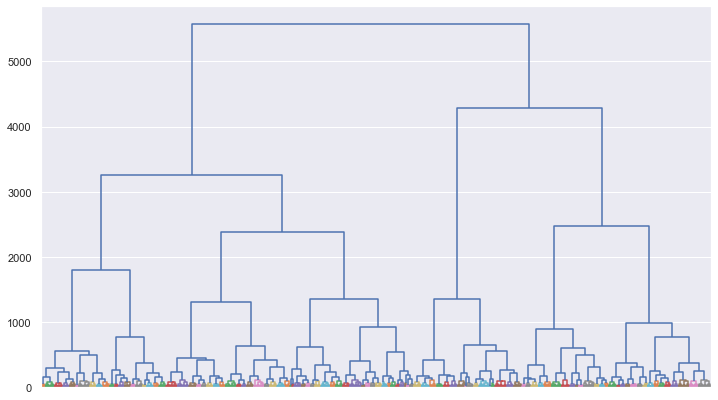

In [135]:
dn = dendrogram(
        distance_matrix,
        leaf_rotation=90.,
        leaf_font_size=8.,
        truncate_mode='level',
        p=16,
        color_threshold=100,
        no_labels=True
    )

In [136]:
#итого было выбрано взять 7 кластеров, далее будет график и подсчет средних значений
cl_tsne_labels_final = pd.Series(fcluster(distance_matrix, 7, criterion='maxclust'))

In [137]:
cl_tsne_labels_final_agg = cl_tsne_labels_final

In [138]:
clusters_df = pd.DataFrame({
    'cl_tsne_labels_final':cl_tsne_labels_final,
    'cl_tsne_labels_final_agg':cl_tsne_labels_final,
    'x':tsne_representation[:,0],
    'y':tsne_representation[:,1]
}
)

In [139]:
import matplotlib.cm as cm
def get_clusters_image(l):
    clusters_df = pd.DataFrame({
        'cl_tsne_labels_final_agg':l,
        'x':tsne_representation[:,0],
        'y':tsne_representation[:,1]
    }
    )
    colors = cm.rainbow(np.linspace(0,1,len(set(l))))
    for y, c in zip(set(l), colors):
        plt.scatter(tsne_representation[pd.Series(l).values==y, 0], 
                    tsne_representation[pd.Series(l).values==y, 1], c=c, alpha=0.3, label=str(y))
    return plt.legend()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

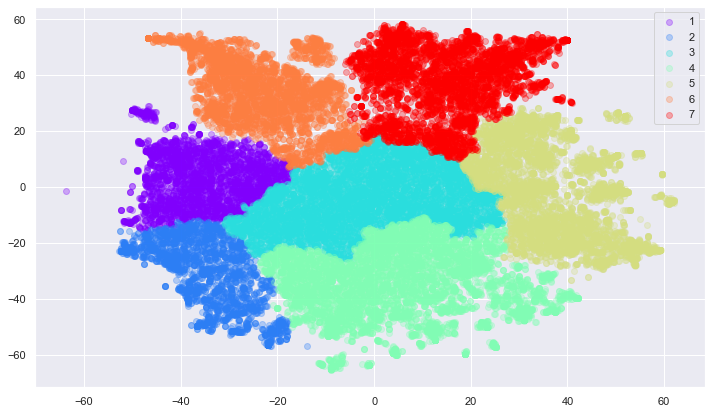

In [140]:
get_clusters_image(cl_tsne_labels_final_agg)

In [141]:
final_df_sample["labels_10"] = cl_tsne_labels_final_agg

In [142]:
final_df_sample

,buyer_id,Автотовары,Аксессуары и галантерея,"Аудио, видео, цифровая техника и аксессу",Багаж,Бакалея,Безалкогольные напитки,Бытовая техника,"Бытовая химия, хозяйственные товары",Вино,...,Функциональное питание,Шоколадные кондитерские изделия,Электротовары,Яйцо,avg_check,revenue,frequency,pcode_orders_percent,express_orders_percent,labels_10
0,95358658,0.000000,0.0,0.0,0.0,0.037730,0.264110,0.000000,0.000000,0.0,...,0.000000,0.015545,0.000000,0.018865,1869.960000,5609.88,3,0.67,0.00,5
1,102253372,0.000000,0.0,0.0,0.0,0.108273,0.162409,0.000000,0.013534,0.0,...,0.000000,0.000000,0.000000,0.000000,2700.420000,8101.26,3,0.00,0.00,2
2,94750195,0.000000,0.0,0.0,0.0,0.078008,0.000000,0.000000,0.031203,0.0,...,0.000000,0.015602,0.000000,0.015602,2349.620000,4699.24,2,0.50,0.00,7
3,95720656,0.000000,0.0,0.0,0.0,0.068259,0.085324,0.000000,0.000000,0.0,...,0.000000,0.051194,0.000000,0.017065,1491.632500,5966.53,4,0.50,0.25,3
4,94674414,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,1719.550000,1719.55,1,1.00,0.00,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,101622537,0.000000,0.0,0.0,0.0,0.000000,0.263072,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,835.715000,1671.43,2,0.50,0.00,5
29996,103402136,0.000000,0.0,0.0,0.0,0.040407,0.022729,0.001263,0.016415,0.0,...,0.000000,0.087179,0.003788,0.002525,1400.765250,56030.61,40,0.03,0.00,3
29997,95914461,0.000000,0.0,0.0,0.0,0.022458,0.636302,0.000000,0.052401,0.0,...,0.000000,0.000000,0.022458,0.000000,1928.935714,13502.55,7,0.71,0.00,5
29998,98438415,0.000000,0.0,0.0,0.0,0.073636,0.039272,0.000000,0.019636,0.0,...,0.000000,0.019636,0.000000,0.024545,2116.826667,12700.96,6,0.50,0.00,6


In [143]:
df_vis = final_df_sample[['Автотовары',
 'Аксессуары и галантерея',
 'Аудио, видео, цифровая техника и аксессу',
 'Багаж',
 'Бакалея',
 'Безалкогольные напитки',
 'Бытовая техника',
 'Бытовая химия, хозяйственные товары',
 'Вино',
 'Гигиенические средства',
 'Деликатесы из рыбы и морепродуктов',
 'Детская гигиена',
 'Детская одежда, обувь и постельные прин',
 'Детское питание',
 'Женская и мужская одежда',
 'Женское и мужское нижнее белье',
 'Живые горшечные цветы, срезка',
 'Закуски к аперитивам',
 'Замороженная рыба',
 'Игрушки',
 'Канцелярия и печатная продукция',
 'Консервы',
 'Косметика и аксессуары',
 'Кофе, какао, чай',
 'Кулинария собственного производства',
 'Майонезы, Закуски, Готовые Блюда охл',
 'Масложировая продукция',
 'Молочные продукты д/детского питания',
 'Морепродукты глубокой заморозки',
 'Мясо глубокой заморозки',
 'Мясо охлажденное',
 'Не шоколадные кондитерские изделия',
 'Овощи',
 'Одежда и товары для новорождённых',
 'Охлажденная и переработанная рыбная прод',
 'П\\ф и другие продукты глубокой заморзк',
 'Пекарня промышленное производство',
 'Пекарня собственное производство',
 'Пиво и слабоалкогольные напитки',
 'Посуда столовая, товары для дома',
 'Продукты мясной переработки',
 'Профессиональные Товары для животных',
 'Птица глубокой заморозки',
 'Птица охлажденная',
 'Современная молочная продукция',
 'Спорт, туризм',
 'Средства персонального ухода',
 'Сыры',
 'Табачные изделия',
 'Текстиль для дома',
 'Товары для акции лояльности КС',
 'Товары для животных',
 'Товары для приготовления',
 'Товары для сада',
 'Товары для уборки и хранения',
 'Товары сделай сам (DIY)',
 'Традиционная молочная продукция',
 'Фрукты',
 'Функциональное питание',
 'Шоколадные кондитерские изделия',
 'Электротовары',
 'Яйцо',
 'avg_check',
 'revenue',
 'frequency',
 'pcode_orders_percent',
 'express_orders_percent',
 'labels_10']].copy()

In [144]:
df_vis_pivot = df_vis.pivot_table(index='labels_10', aggfunc='mean').transpose().reset_index()

In [145]:
df_vis_pivot.to_excel('clusters_19.xlsx')

In [146]:
final_df_sample.to_excel('final_df_sample_19.xlsx')

In [147]:
final_df_sample.groupby('labels_10')['buyer_id'].nunique()

labels_10
1    2918
2    2437
3    5537
4    5861
5    4710
6    3910
7    4627
Name: buyer_id, dtype: int64

In [52]:
age_and_sex = '''
select o.buyer_id, extract('year' from date(now())) - extract('year' from date(bdate)) as age, 
       case when sex = 1 then 0 
            else 1 end as sex
from dwh_datamart.ops_metrics o left join dwh_stage.utk_sess_session_bonus p
on o.buyer_id = p.buyer_id
where date between '2022-03-26' and '2023-03-26'
and flag_cancel = 0
and order_source IN ('iOS', 'Android')
and sex != 0
and bdate is not null
group by 1,2,3
'''

In [53]:
demographics = pd.read_sql(age_and_sex, postrge_conn)

In [54]:
demographics

,buyer_id,age,sex
0,94025409,36.0,0
1,94205486,31.0,1
2,94578440,25.0,0
3,94578442,38.0,0
4,94578489,34.0,1
...,...,...,...
289878,104938305,47.0,0
289879,104938505,26.0,1
289880,104938671,52.0,1
289881,104938714,61.0,0


In [55]:
additional = final_df_sample.merge(demographics, on = 'buyer_id', how = 'inner')

In [56]:
additional

,buyer_id,Автотовары,Аксессуары и галантерея,"Аудио, видео, цифровая техника и аксессу",Багаж,Бакалея,Безалкогольные напитки,Бытовая техника,"Бытовая химия, хозяйственные товары",Вино,...,Электротовары,Яйцо,avg_check,revenue,frequency,pcode_orders_percent,express_orders_percent,labels_10,age,sex
0,95425707,0.0,0.0,0.0,0.0,0.074947,0.034591,0.0,0.069182,0.0,...,0.0,0.000000,3499.766000,17498.83,5,0.00,0.0,6,37.0,1
1,101609157,0.0,0.0,0.0,0.0,0.063602,0.212007,0.0,0.053002,0.0,...,0.0,0.021201,2083.577500,8334.31,4,0.00,0.0,4,88.0,1
2,97369396,0.0,0.0,0.0,0.0,0.048221,0.048221,0.0,0.000000,0.0,...,0.0,0.042863,1830.920000,12816.44,7,0.43,0.0,2,22.0,1
3,96782901,0.0,0.0,0.0,0.0,0.142857,0.000000,0.0,0.000000,0.0,...,0.0,0.142857,1672.310000,1672.31,1,1.00,0.0,2,27.0,1
4,95818174,0.0,0.0,0.0,0.0,0.333333,0.037037,0.0,0.111111,0.0,...,0.0,0.037037,2822.880000,2822.88,1,0.00,0.0,5,46.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8925,96548822,0.0,0.0,0.0,0.0,0.020970,0.125818,0.0,0.083879,0.0,...,0.0,0.000000,1665.375000,3330.75,2,0.50,0.0,1,37.0,1
8926,95663526,0.0,0.0,0.0,0.0,0.065872,0.074855,0.0,0.020959,0.0,...,0.0,0.002994,3631.675556,32685.08,9,0.11,0.0,4,30.0,0
8927,101919923,0.0,0.0,0.0,0.0,0.052476,0.295180,0.0,0.019679,0.0,...,0.0,0.013119,7408.480000,14816.96,2,0.00,0.0,1,49.0,1
8928,101582107,0.0,0.0,0.0,0.0,0.135550,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,1191.274000,5956.37,5,0.00,0.0,5,26.0,0


In [59]:
pd.DataFrame(additional.pivot_table(index='labels_10', aggfunc='mean'))[['sex']].transpose()

labels_10,1,2,3,4,5,6,7,8,9,10
sex,0.819913,0.885496,0.855,0.820652,0.828092,0.823467,0.824468,0.900198,0.798137,0.777209


In [181]:
final_df_sample['final_clusters'] = final_df_sample[['labels_10', 'Бакалея', 'Безалкогольные напитки', 'Бытовая химия, хозяйственные товары', \
                                                    'Детское питание', 'Консервы', 'Молочные продукты д/детского питания', 'Мясо охлажденное', \
                                                     'Не шоколадные кондитерские изделия', 'Овощи', 'П\ф и другие продукты глубокой заморзк', \
                                                     'Птица охлажденная', 'Современная молочная продукция', 'Сыры', 'Товары для животных', \
                                                     'Традиционная молочная продукция', 'Фрукты', 'Шоколадные кондитерские изделия' \
                                                    ]].apply(lambda x: 8 \
                                                             if (x['labels_10'] == 1  and (x['Фрукты'] <= 0.01 or x['Овощи'] <= 0.01)) \
                                                             or (x['labels_10'] == 2 and (x['Овощи'] <= 0.01 or x['Мясо охлажденное']<= 0.01 or x['Птица охлажденная']<= 0.01)) \
                                                             or (x['labels_10'] == 3 and (x['Овощи'] <= 0.01 or x['Фрукты'] <= 0.01 or x['Традиционная молочная продукция'] <= 0.01 \
                                                                 or x['Сыры'] <= 0.01)) \
                                                             or (x['labels_10'] == 4 and (x['Бакалея'] <= 0.01 or x['Консервы'] <= 0.01 \
                                                                 or x['Бытовая химия, хозяйственные товары'] <= 0.01 or x['П\ф и другие продукты глубокой заморзк']\
                                                                 or x['П\ф и другие продукты глубокой заморзк']))
                                                             or (x['labels_10'] == 5 and (x['Безалкогольные напитки']<= 0.01 or x['Не шоколадные кондитерские изделия']<= 0.01 \
                                                                 or x['Современная молочная продукция']<= 0.01 or x['Шоколадные кондитерские изделия']<= 0.01))
                                                             or (x['labels_10'] == 6 and (x['Товары для животных']<= 0.01)) \
                                                             or (x['labels_10'] == 7 and (x['Детское питание']<= 0.01 or x['Молочные продукты д/детского питания']<= 0.01)) \
                                                             else x['labels_10'], axis=1)

In [182]:
final_df_sample.groupby('final_clusters')['buyer_id'].nunique()

final_clusters
1.0     2658
2.0      797
3.0     3527
4.0      689
5.0      871
6.0     3500
7.0     1903
8.0    16055
Name: buyer_id, dtype: int64

In [173]:
#final_df_sample.to_excel('final_clusters_df.xlsx')

In [423]:
final_df_sample = pd.read_excel('C:/Users/a.al.kosheleva/analytics/kosheleva_a/final_clusters_df.xlsx')

Exception during reset or similar
Traceback (most recent call last):
  File "C:\Users\a.al.kosheleva\Anaconda3\lib\site-packages\sqlalchemy\pool\base.py", line 682, in _finalize_fairy
    fairy._reset(pool)
  File "C:\Users\a.al.kosheleva\Anaconda3\lib\site-packages\sqlalchemy\pool\base.py", line 887, in _reset
    pool._dialect.do_rollback(self)
  File "C:\Users\a.al.kosheleva\Anaconda3\lib\site-packages\sqlalchemy\engine\default.py", line 667, in do_rollback
    dbapi_connection.rollback()
psycopg2.OperationalError: could not receive data from server: Software caused connection abort (0x00002745/10053)
SSL SYSCALL error: Software caused connection abort (0x00002745/10053)



In [424]:
final_df_sample['final_clusters'] = final_df_sample[['labels_10', 'Бакалея', 'Безалкогольные напитки', 'Бытовая химия, хозяйственные товары', \
                                                    'Детское питание', 'Консервы', 'Молочные продукты д/детского питания', 'Мясо охлажденное', \
                                                     'Не шоколадные кондитерские изделия', 'Овощи', 'П\ф и другие продукты глубокой заморзк', \
                                                     'Птица охлажденная', 'Современная молочная продукция', 'Сыры', 'Товары для животных', \
                                                     'Традиционная молочная продукция', 'Фрукты', 'Шоколадные кондитерские изделия' \
                                                    ]].apply(lambda x: 8 \
                                                             if (x['labels_10'] == 1  and (x['Фрукты'] <= 0.01 or x['Овощи'] <= 0.01)) \
                                                             or (x['labels_10'] == 2 and (x['Овощи'] <= 0.01 or x['Мясо охлажденное']<= 0.01 or x['Птица охлажденная']<= 0.01)) \
                                                             or (x['labels_10'] == 3 and (x['Овощи'] <= 0.01 or x['Фрукты'] <= 0.01 or x['Традиционная молочная продукция'] <= 0.01 \
                                                                 or x['Сыры'] <= 0.01)) \
                                                             or (x['labels_10'] == 4 and (x['Бакалея'] <= 0.01 or x['Консервы'] <= 0.01 \
                                                                 or x['Бытовая химия, хозяйственные товары'] <= 0.01 or x['П\ф и другие продукты глубокой заморзк']\
                                                                 or x['П\ф и другие продукты глубокой заморзк']))
                                                             or (x['labels_10'] == 5 and (x['Безалкогольные напитки']<= 0.01 or x['Не шоколадные кондитерские изделия']<= 0.01 \
                                                                 or x['Современная молочная продукция']<= 0.01 or x['Шоколадные кондитерские изделия']<= 0.01))
                                                             or (x['labels_10'] == 6 and (x['Товары для животных']<= 0.01)) \
                                                             or (x['labels_10'] == 7 and (x['Детское питание']<= 0.01 or x['Молочные продукты д/детского питания']<= 0.01)) \
                                                             else x['labels_10'], axis=1)

In [488]:
final_df_sample.pivot_table(index='final_clusters', aggfunc='mean').transpose().reset_index().to_excel('check_last_clust.xlsx')

In [360]:
df_vis_pivot = final_df_sample.pivot_table(index='final_clusters', aggfunc='mean').transpose().reset_index()

In [361]:
#df_vis_pivot.to_excel('check_clusters.xlsx')

In [362]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
#from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [433]:
df_cl = final_df_sample[['Автотовары', 'Аксессуары и галантерея',
       'Аудио, видео, цифровая техника и аксессу', 'Багаж', 'Бакалея',
       'Безалкогольные напитки', 'Бытовая техника',
       'Бытовая химия, хозяйственные товары', 'Вино', 'Гигиенические средства',
       'Деликатесы из рыбы и морепродуктов', 'Детская гигиена',
       'Детская одежда, обувь и постельные прин', 'Детское питание',
       'Женская и мужская одежда', 'Женское и мужское нижнее белье',
       'Живые горшечные цветы, срезка', 'Закуски к аперитивам',
       'Замороженная рыба', 'Игрушки', 'Канцелярия и печатная продукция',
       'Консервы', 'Косметика и аксессуары', 'Кофе, какао, чай',
       'Кулинария собственного производства',
       'Майонезы, Закуски, Готовые Блюда охл', 
       'Масложировая продукция', 'Молочные продукты д/детского питания',
       'Морепродукты глубокой заморозки', 'Мясо глубокой заморозки',
       'Мясо охлажденное', 'Не шоколадные кондитерские изделия', 'Овощи',
       'Одежда и товары для новорождённых',
       'Охлажденная и переработанная рыбная прод',
       'П\ф и другие продукты глубокой заморзк',
       'Пекарня промышленное производство', 'Пекарня собственное производство',
       'Пиво и слабоалкогольные напитки', 'Посуда столовая, товары для дома',
       'Продукты мясной переработки', 'Профессиональные Товары для животных',
       'Птица глубокой заморозки', 'Птица охлажденная',
       'Современная молочная продукция', 'Спорт, туризм',
       'Средства персонального ухода', 'Сыры', 'Табачные изделия',
       'Текстиль для дома', 'Товары для акции лояльности КС',
       'Товары для животных', 'Товары для приготовления', 'Товары для сада',
       'Товары для уборки и хранения', 'Товары сделай сам (DIY)',
       'Традиционная молочная продукция', 'Фрукты', 'Функциональное питание',
       'Шоколадные кондитерские изделия', 'Электротовары', 'Яйцо', 
        'avg_check',
       'revenue', 'frequency', 'pcode_orders_percent', 'final_clusters']]

In [441]:
for el in set(df_cl['final_clusters']):
    df_cl[f'y_{el}'] = (df_cl['final_clusters'] == el).astype(int)
    print(f'y_{el}')

y_1.0
y_2.0
y_3.0
y_4.0
y_5.0
y_6.0
y_7.0
y_8.0


In [445]:
#выделяем выбросы - по чеку или выручке на пользователя
df_cl = df_cl.merge(
    df_cl.groupby('final_clusters').agg({'avg_check':lambda x: np.percentile(x, 99)}).reset_index().rename(columns={'avg_check':'avg_check_outl'}),
    how = 'left',
    on='final_clusters').copy()

In [446]:
df_cl['outlier'] = (((df_cl['avg_check'] >= df_cl['avg_check_outl']).astype(int) >=1).astype(int))

In [447]:
df_cl

,Автотовары,Аксессуары и галантерея,"Аудио, видео, цифровая техника и аксессу",Багаж,Бакалея,Безалкогольные напитки,Бытовая техника,"Бытовая химия, хозяйственные товары",Вино,Гигиенические средства,...,y_3.0,y_4.0,y_5.0,y_6.0,y_7.0,y_8.0,avg_check_outl_x,outlier,avg_check_outl_y,avg_check_outl
0,0.000000,0.0,0.0,0.0,0.037730,0.264110,0.000000,0.000000,0.0,0.018865,...,0,0,0,0,0,1,6236.029533,0,6236.029533,6236.029533
1,0.000000,0.0,0.0,0.0,0.108273,0.162409,0.000000,0.013534,0.0,0.027068,...,0,0,0,0,0,1,6236.029533,0,6236.029533,6236.029533
2,0.000000,0.0,0.0,0.0,0.078008,0.000000,0.000000,0.031203,0.0,0.015602,...,0,0,0,0,1,0,6807.208956,0,6807.208956,6807.208956
3,0.000000,0.0,0.0,0.0,0.068259,0.085324,0.000000,0.000000,0.0,0.000000,...,1,0,0,0,0,0,7103.404040,0,7103.404040,7103.404040
4,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0,0,0,0,0,1,6236.029533,0,6236.029533,6236.029533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.000000,0.0,0.0,0.0,0.000000,0.263072,0.000000,0.000000,0.0,0.087691,...,0,0,0,0,0,1,6236.029533,0,6236.029533,6236.029533
29996,0.000000,0.0,0.0,0.0,0.040407,0.022729,0.001263,0.016415,0.0,0.023992,...,0,0,0,0,0,1,6236.029533,0,6236.029533,6236.029533
29997,0.000000,0.0,0.0,0.0,0.022458,0.636302,0.000000,0.052401,0.0,0.022458,...,0,0,0,0,0,1,6236.029533,0,6236.029533,6236.029533
29998,0.000000,0.0,0.0,0.0,0.073636,0.039272,0.000000,0.019636,0.0,0.058908,...,0,0,0,1,0,0,6598.356817,0,6598.356817,6598.356817


In [448]:
df_cl['outlier'] = [*map(lambda x: 0 if x[0] == 4 else x[1], list(zip(df_cl['final_clusters'], df_cl['outlier'])))]

In [449]:
df_cl_f = df_cl.query('outlier==0').drop(columns=['avg_check_outl', 'outlier']).copy()

In [451]:
def get_log_df(data):
    def log_transform(v): 
        res = np.log(v+1)
        return res
    
    data_tmp = data.copy()
    for el in ['Автотовары', 'Аксессуары и галантерея',
       'Аудио, видео, цифровая техника и аксессу', 'Багаж', 'Бакалея',
       'Безалкогольные напитки', 'Бытовая техника',
       'Бытовая химия, хозяйственные товары', 'Вино', 'Гигиенические средства',
       'Деликатесы из рыбы и морепродуктов', 'Детская гигиена',
       'Детская одежда, обувь и постельные прин', 'Детское питание',
       'Женская и мужская одежда', 'Женское и мужское нижнее белье',
       'Живые горшечные цветы, срезка', 'Закуски к аперитивам',
       'Замороженная рыба', 'Игрушки', 'Канцелярия и печатная продукция',
       'Консервы', 'Косметика и аксессуары', 'Кофе, какао, чай',
       'Кулинария собственного производства',
       'Майонезы, Закуски, Готовые Блюда охл',
       'Масложировая продукция', 'Молочные продукты д/детского питания',
       'Морепродукты глубокой заморозки', 'Мясо глубокой заморозки',
       'Мясо охлажденное', 'Не шоколадные кондитерские изделия', 'Овощи',
       'Одежда и товары для новорождённых',
       'Охлажденная и переработанная рыбная прод',
       'П\ф и другие продукты глубокой заморзк',
       'Пекарня промышленное производство', 'Пекарня собственное производство',
       'Пиво и слабоалкогольные напитки', 'Посуда столовая, товары для дома',
       'Продукты мясной переработки', 'Профессиональные Товары для животных',
       'Птица глубокой заморозки', 'Птица охлажденная',
       'Современная молочная продукция', 'Спорт, туризм',
       'Средства персонального ухода', 'Сыры', 'Табачные изделия',
       'Текстиль для дома', 'Товары для акции лояльности КС',
       'Товары для животных', 'Товары для приготовления', 'Товары для сада',
       'Товары для уборки и хранения', 'Товары сделай сам (DIY)',
       'Традиционная молочная продукция', 'Фрукты', 'Функциональное питание',
       'Шоколадные кондитерские изделия', 'Электротовары', 'Яйцо']:
        data_tmp[el] = data_tmp[el].apply(lambda x: log_transform(x))
    return data_tmp

In [452]:
df_cl_f_l = get_log_df(df_cl_f.copy())

In [453]:
df_cl_f_l

,Автотовары,Аксессуары и галантерея,"Аудио, видео, цифровая техника и аксессу",Багаж,Бакалея,Безалкогольные напитки,Бытовая техника,"Бытовая химия, хозяйственные товары",Вино,Гигиенические средства,...,y_1.0,y_2.0,y_3.0,y_4.0,y_5.0,y_6.0,y_7.0,y_8.0,avg_check_outl_x,avg_check_outl_y
0,0.000000,0.0,0.0,0.0,0.037036,0.234368,0.000000,0.000000,0.0,0.018689,...,0,0,0,0,0,0,0,1,6236.029533,6236.029533
1,0.000000,0.0,0.0,0.0,0.102803,0.150494,0.000000,0.013443,0.0,0.026708,...,0,0,0,0,0,0,0,1,6236.029533,6236.029533
2,0.000000,0.0,0.0,0.0,0.075115,0.000000,0.000000,0.030726,0.0,0.015481,...,0,0,0,0,0,0,1,0,6807.208956,6807.208956
3,0.000000,0.0,0.0,0.0,0.066030,0.081878,0.000000,0.000000,0.0,0.000000,...,0,0,1,0,0,0,0,0,7103.404040,7103.404040
4,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0,0,0,0,0,0,0,1,6236.029533,6236.029533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.000000,0.0,0.0,0.0,0.000000,0.233547,0.000000,0.000000,0.0,0.084057,...,0,0,0,0,0,0,0,1,6236.029533,6236.029533
29996,0.000000,0.0,0.0,0.0,0.039612,0.022475,0.001262,0.016282,0.0,0.023709,...,0,0,0,0,0,0,0,1,6236.029533,6236.029533
29997,0.000000,0.0,0.0,0.0,0.022209,0.492439,0.000000,0.051075,0.0,0.022209,...,0,0,0,0,0,0,0,1,6236.029533,6236.029533
29998,0.000000,0.0,0.0,0.0,0.071051,0.038521,0.000000,0.019446,0.0,0.057239,...,0,0,0,0,0,1,0,0,6598.356817,6598.356817


## Деление на train и test

In [454]:
def get_train_test_samples(data):
    X = data[['Автотовары',
 'Аксессуары и галантерея',
 'Аудио, видео, цифровая техника и аксессу',
 'Багаж',
 'Бакалея',
 'Безалкогольные напитки',
 'Бытовая техника',
 'Бытовая химия, хозяйственные товары',
 'Вино',
 'Гигиенические средства',
 'Деликатесы из рыбы и морепродуктов',
 'Детская гигиена',
 'Детская одежда, обувь и постельные прин',
 'Детское питание',
 'Женская и мужская одежда',
 'Женское и мужское нижнее белье',
 'Живые горшечные цветы, срезка',
 'Закуски к аперитивам',
 'Замороженная рыба',
 'Игрушки',
 'Канцелярия и печатная продукция',
 'Консервы',
 'Косметика и аксессуары',
 'Кофе, какао, чай',
 'Кулинария собственного производства',
 'Майонезы, Закуски, Готовые Блюда охл',
 'Масложировая продукция',
 'Молочные продукты д/детского питания',
 'Морепродукты глубокой заморозки',
 'Мясо глубокой заморозки',
 'Мясо охлажденное',
 'Не шоколадные кондитерские изделия',
 'Овощи',
 'Одежда и товары для новорождённых',
 'Охлажденная и переработанная рыбная прод',
 'П\\ф и другие продукты глубокой заморзк',
 'Пекарня промышленное производство',
 'Пекарня собственное производство',
 'Пиво и слабоалкогольные напитки',
 'Посуда столовая, товары для дома',
 'Продукты мясной переработки',
 'Профессиональные Товары для животных',
 'Птица глубокой заморозки',
 'Птица охлажденная',
 'Современная молочная продукция',
 'Спорт, туризм',
 'Средства персонального ухода',
 'Сыры',
 'Табачные изделия',
 'Текстиль для дома',
 'Товары для акции лояльности КС',
 'Товары для животных',
 'Товары для приготовления',
 'Товары для сада',
 'Товары для уборки и хранения',
 'Товары сделай сам (DIY)',
 'Традиционная молочная продукция',
 'Фрукты',
 'Функциональное питание',
 'Шоколадные кондитерские изделия',
 'Электротовары',
 'Яйцо']].copy()
    y1 = data['final_clusters'].copy()
    (X_train, X_test, y_train_1, y_test_1) = train_test_split(X, y1, test_size=0.25, random_state=0, shuffle=True)
    
    sc = StandardScaler()
    X_train_sc = sc.fit_transform(X_train)
    X_test_sc = sc.transform(X_test)
    
    return X_train_sc, X_test_sc, y_train_1, y_test_1, sc

In [455]:
(X_train_sc, X_test_sc, y_train_1, y_test_1, sc) = get_train_test_samples(df_cl_f_l)

# Кросс-валидация

In [456]:
# какие гипер-параметры тестировались
params = {
    'random_state':[0]
    , 'learning_rate':[0.05, 0.1, 0.15, 0.25, 0.3]
    #, 'n_estimators':[100, 200, 300,500,1000]
    #, 'max_depth':[3,5,7]
    #, 'subsample':[0.3, 0.5, 0.7]
    #, 'colsample_bylevel':[0.3, 0.5, 0.7]
}

In [457]:
clf = LGBMClassifier(objective='multi:softmax')
CVSS = StratifiedShuffleSplit(n_splits=3, random_state=0, test_size=0.3)
opt_1 = GridSearchCV(clf, param_grid=params,cv=CVSS, scoring='roc_auc_ovr')
opt_1.fit(X_train_sc, y_train_1)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=3, random_state=0, test_size=0.3,
            train_size=None),
             estimator=LGBMClassifier(objective='multi:softmax'),
             param_grid={'learning_rate': [0.05, 0.1, 0.15, 0.25, 0.3],
                         'random_state': [0]},
             scoring='roc_auc_ovr')

In [458]:
opt_1.best_params_

{'learning_rate': 0.1, 'random_state': 0}

In [459]:
# какие гипер-параметры тестировал
params = {
    'random_state':[0]
    #, 'learning_rate':[0.05, 0.1, 0.15, 0.25, 0.3]
    , 'n_estimators':[100, 200, 300,500,1000]
    #, 'max_depth':[3,5,7]
    #, 'subsample':[0.3, 0.5, 0.7]
    #, 'colsample_bylevel':[0.3, 0.5, 0.7]
}

In [460]:
clf = LGBMClassifier(objective='multi:softmax')
CVSS = StratifiedShuffleSplit(n_splits=3, random_state=0, test_size=0.3)
opt_2 = GridSearchCV(clf, param_grid=params,cv=CVSS, scoring='roc_auc_ovr')
opt_2.fit(X_train_sc, y_train_1)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=3, random_state=0, test_size=0.3,
            train_size=None),
             estimator=LGBMClassifier(objective='multi:softmax'),
             param_grid={'n_estimators': [100, 200, 300, 500, 1000],
                         'random_state': [0]},
             scoring='roc_auc_ovr')

In [461]:
opt_2.best_params_

{'n_estimators': 200, 'random_state': 0}

In [462]:
# какие гипер-параметры тестировал
params = {
    'random_state':[0]
    #, 'learning_rate':[0.05, 0.1, 0.15, 0.25, 0.3]
    #, 'n_estimators':[100, 200, 300,500,1000]
    , 'max_depth':[3,5,7]
    #, 'subsample':[0.3, 0.5, 0.7]
    #, 'colsample_bylevel':[0.3, 0.5, 0.7]
}

In [463]:
clf = LGBMClassifier(objective='multi:softmax')
CVSS = StratifiedShuffleSplit(n_splits=3, random_state=0, test_size=0.3)
opt_3 = GridSearchCV(clf, param_grid=params,cv=CVSS, scoring='roc_auc_ovr')
opt_3.fit(X_train_sc, y_train_1)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=3, random_state=0, test_size=0.3,
            train_size=None),
             estimator=LGBMClassifier(objective='multi:softmax'),
             param_grid={'max_depth': [3, 5, 7], 'random_state': [0]},
             scoring='roc_auc_ovr')

In [464]:
opt_3.best_params_

{'max_depth': 7, 'random_state': 0}

In [465]:
# какие гипер-параметры тестировал
params = {
    'random_state':[0]
    #, 'learning_rate':[0.05, 0.1, 0.15, 0.25, 0.3]
    #, 'n_estimators':[100, 200, 300,500,1000]
    #, 'max_depth':[3,5,7]
    , 'subsample':[0.3, 0.5, 0.7]
    #, 'colsample_bylevel':[0.3, 0.5, 0.7]
}

In [466]:
clf = LGBMClassifier(objective='multi:softmax')
CVSS = StratifiedShuffleSplit(n_splits=3, random_state=0, test_size=0.3)
opt_4 = GridSearchCV(clf, param_grid=params,cv=CVSS, scoring='roc_auc_ovr')
opt_4.fit(X_train_sc, y_train_1)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=3, random_state=0, test_size=0.3,
            train_size=None),
             estimator=LGBMClassifier(objective='multi:softmax'),
             param_grid={'random_state': [0], 'subsample': [0.3, 0.5, 0.7]},
             scoring='roc_auc_ovr')

In [467]:
opt_4.best_params_

{'random_state': 0, 'subsample': 0.3}

In [468]:
# какие гипер-параметры тестировал
params = {
    'random_state':[0]
    #, 'learning_rate':[0.05, 0.1, 0.15, 0.25, 0.3]
    #, 'n_estimators':[100, 200, 300,500,1000]
    #, 'max_depth':[3,5,7]
    #, 'subsample':[0.3, 0.5, 0.7]
    , 'colsample_bytree':[0.3, 0.5, 0.7, 1]
}

In [469]:
clf = LGBMClassifier(objective='multi:softmax')
CVSS = StratifiedShuffleSplit(n_splits=3, random_state=0, test_size=0.3)
opt_5 = GridSearchCV(clf, param_grid=params,cv=CVSS, scoring='roc_auc_ovr')
opt_5.fit(X_train_sc, y_train_1)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=3, random_state=0, test_size=0.3,
            train_size=None),
             estimator=LGBMClassifier(objective='multi:softmax'),
             param_grid={'colsample_bytree': [0.3, 0.5, 0.7, 1],
                         'random_state': [0]},
             scoring='roc_auc_ovr')

In [470]:
opt_5.best_params_

{'colsample_bytree': 0.7, 'random_state': 0}

In [471]:
import joblib

In [472]:
#этот параметр сохраняет наши решения
joblib.dump(opt_1, 'opt_1.pkl')
joblib.dump(opt_2, 'opt_2.pkl')
joblib.dump(opt_3, 'opt_3.pkl')
joblib.dump(opt_4, 'opt_4.pkl')
joblib.dump(opt_5, 'opt_5.pkl')

['opt_5.pkl']

In [473]:
opt_1.best_params_

{'learning_rate': 0.1, 'random_state': 0}

In [474]:
opt_2.best_params_

{'n_estimators': 200, 'random_state': 0}

In [475]:
opt_3.best_params_

{'max_depth': 7, 'random_state': 0}

In [476]:
opt_4.best_params_

{'random_state': 0, 'subsample': 0.3}

In [477]:
opt_5.best_params_

{'colsample_bytree': 0.7, 'random_state': 0}

In [478]:
opt_1.best_score_

0.9921317290144672

# Обучение модели

In [479]:
(X_train_sc, X_test_sc, y_train_1, y_test_1, sc) = get_train_test_samples(df_cl)

In [480]:
clf_1 = LGBMClassifier(
    random_state=0
    , learning_rate=0.1
    , n_estimators=200
    , max_depth=7
    , subsample=0.3
    , colsample_bytree=0.7
    , objective='multi:softmax'
)
clf_1.fit(X_train_sc, y_train_1)

LGBMClassifier(colsample_bytree=0.7, max_depth=7, n_estimators=200,
               objective='multi:softmax', random_state=0, subsample=0.3)

In [481]:
import pickle

In [482]:
pickle.dump(sc, open("sc_stb.dat", "wb"))
pickle.dump(clf_1, open("clf_stb.dat", "wb"))

In [483]:
clf_1 = pickle.load(open("clf_stb.dat", "rb"))

In [484]:
def get_metrics():
    d_y = {}
    for el in list(set(y_test_1)):
        d_y[el] = [*map(lambda x: 1 if x == el else 0, list(y_test_1))]
    
    d_y_pred = {}
    for el in list(set(clf_1.predict(X_test_sc))):
        d_y_pred[el] = [*map(lambda x: 1 if x == el else 0, list(clf_1.predict(X_test_sc)))]
    
    results = pd.DataFrame()
    for el in list(set(y_test_1)):
        tmp_y = d_y[el] 
        tmp_y_pred = d_y_pred[el]
        
        m_acc = f'accuracy: {round(accuracy_score(tmp_y, tmp_y_pred), 4)}'
        m_pre = f'precision: {round(precision_score(tmp_y, tmp_y_pred), 4)}'
        m_rec = f'recall: {round(recall_score(tmp_y, tmp_y_pred), 4)}'
        m_f1 = f'f1 score: {round(f1_score(tmp_y, tmp_y_pred), 4)}'
        
        results = results.append(pd.DataFrame({
            'class':[el],
            'accuracy':[m_acc],
            'precision':[m_pre],
            'recall':[m_rec],
            'f1 score':[m_f1]
        }))
        
    return results

In [485]:
get_metrics()

,class,accuracy,precision,recall,f1 score
0,1.0,accuracy: 0.9745,precision: 0.8727,recall: 0.8405,f1 score: 0.8563
0,2.0,accuracy: 0.9929,precision: 0.9104,recall: 0.8394,f1 score: 0.8735
0,3.0,accuracy: 0.9501,precision: 0.7286,recall: 0.8504,f1 score: 0.7848
0,4.0,accuracy: 0.9935,precision: 0.8824,recall: 0.838,f1 score: 0.8596
0,5.0,accuracy: 0.9923,precision: 0.9163,recall: 0.8194,f1 score: 0.8651
0,6.0,accuracy: 0.9897,precision: 0.9668,recall: 0.9434,f1 score: 0.9549
0,7.0,accuracy: 0.9932,precision: 0.9356,recall: 0.9607,f1 score: 0.948
0,8.0,accuracy: 0.9273,precision: 0.9382,recall: 0.9264,f1 score: 0.9323


Детское питание


<AxesSubplot:xlabel='labels_10', ylabel='Детское питание'>

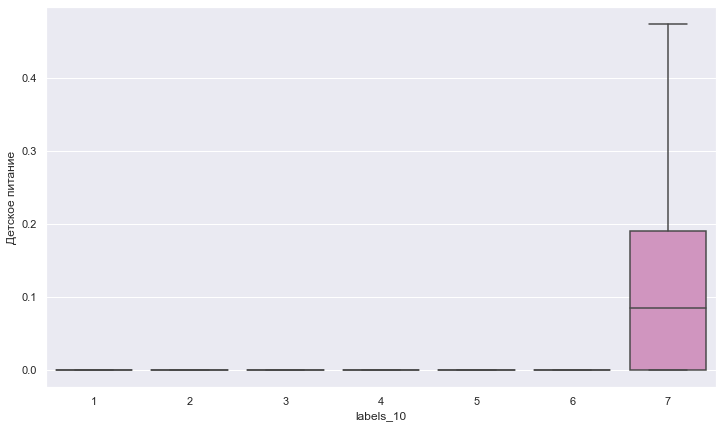

In [490]:
print("Детское питание")
sns.boxplot(x="labels_10", y="Детское питание", data=final_df_sample, showfliers = False)

Товары для животных


<AxesSubplot:xlabel='labels_10', ylabel='Товары для животных'>

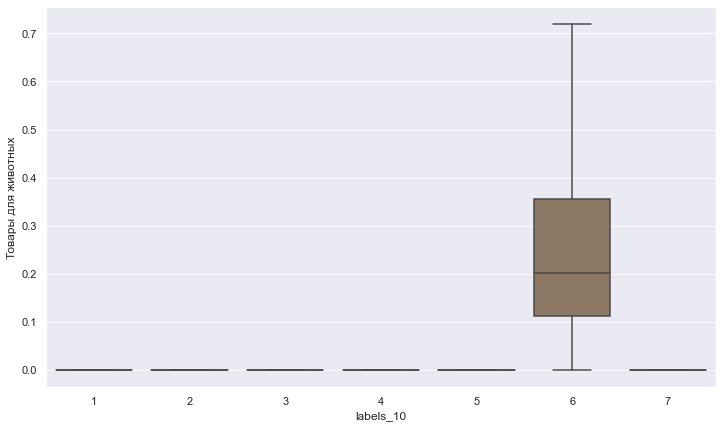

In [491]:
print("Товары для животных")
sns.boxplot(x="labels_10", y="Товары для животных", data=final_df_sample, showfliers = False)

Птица охлажденная


<AxesSubplot:xlabel='labels_10', ylabel='Птица охлажденная'>

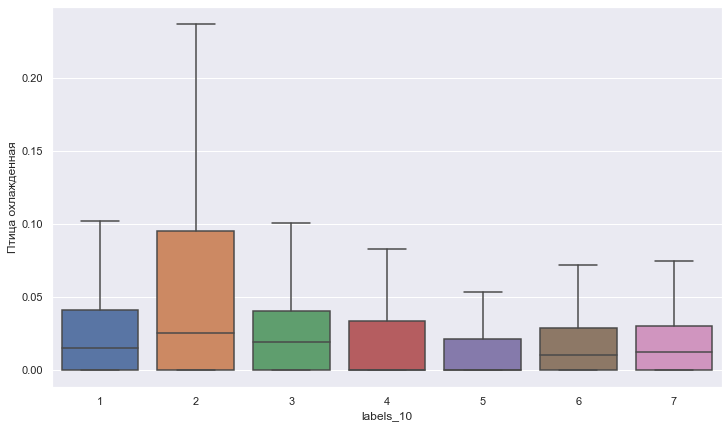

In [492]:
print("Птица охлажденная")
sns.boxplot(x="labels_10", y="Птица охлажденная", data=final_df_sample, showfliers = False)

Мясо охлажденное


<AxesSubplot:xlabel='labels_10', ylabel='Мясо охлажденное'>

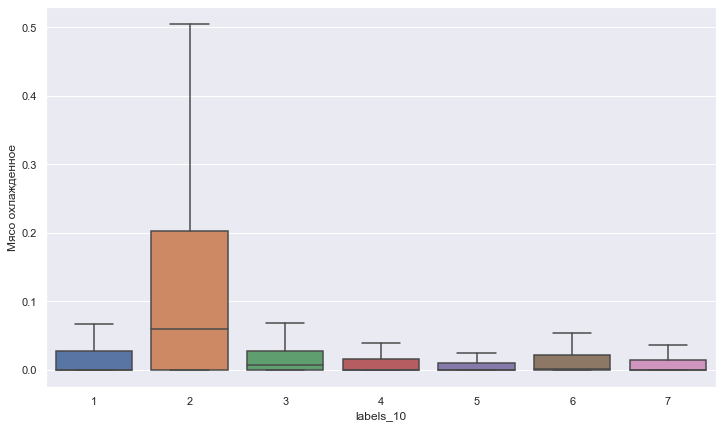

In [493]:
print("Мясо охлажденное")
sns.boxplot(x="labels_10", y="Мясо охлажденное", data=final_df_sample, showfliers = False)

Овощи


<AxesSubplot:xlabel='labels_10', ylabel='Овощи'>

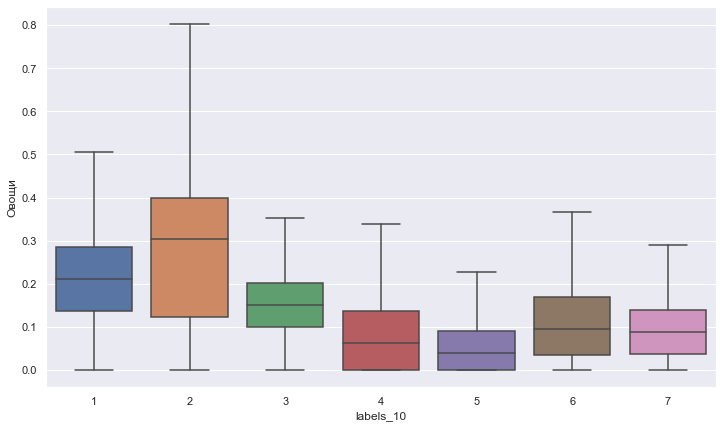

In [494]:
print("Овощи")
sns.boxplot(x="labels_10", y="Овощи", data=final_df_sample, showfliers = False)

Фрукты


<AxesSubplot:xlabel='labels_10', ylabel='Фрукты'>

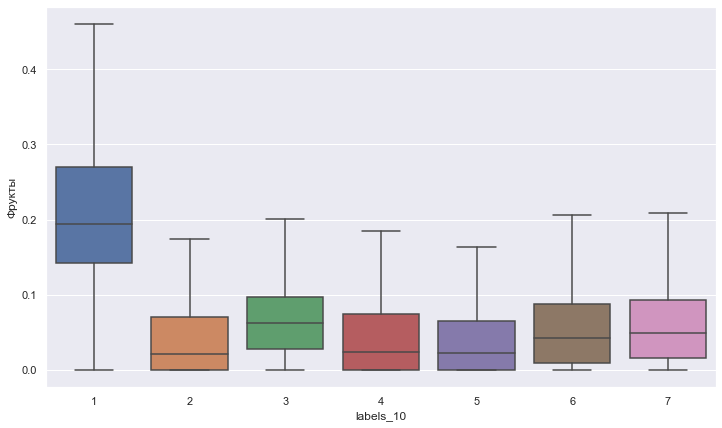

In [495]:
print("Фрукты")
sns.boxplot(x="labels_10", y="Фрукты", data=final_df_sample, showfliers = False)

Традиционная молочная продукция


<AxesSubplot:xlabel='labels_10', ylabel='Традиционная молочная продукция'>

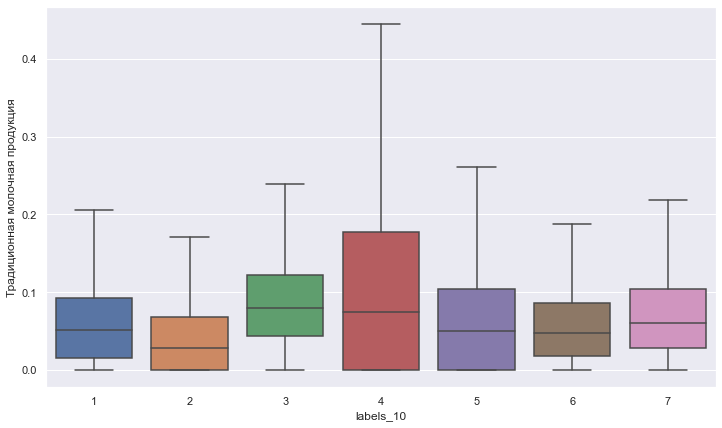

In [497]:
print("Традиционная молочная продукция")
sns.boxplot(x="labels_10", y="Традиционная молочная продукция", data=final_df_sample, showfliers = False)

Современная молочная продукция


<AxesSubplot:xlabel='labels_10', ylabel='Современная молочная продукция'>

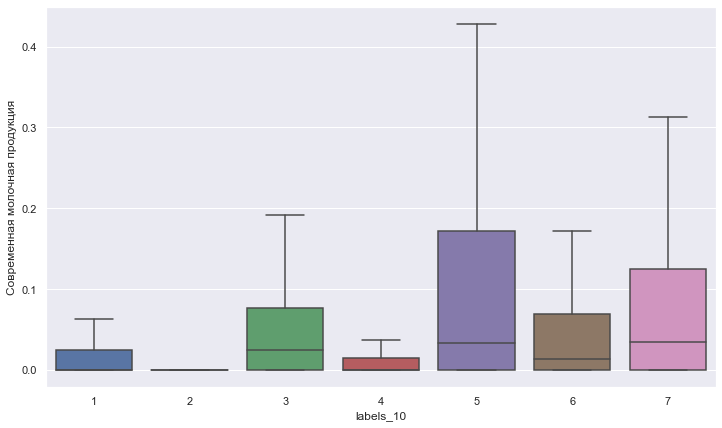

In [498]:
print("Современная молочная продукция")
sns.boxplot(x="labels_10", y="Современная молочная продукция", data=final_df_sample, showfliers = False)

Не шоколадные кондитерские изделия


<AxesSubplot:xlabel='labels_10', ylabel='Не шоколадные кондитерские изделия'>

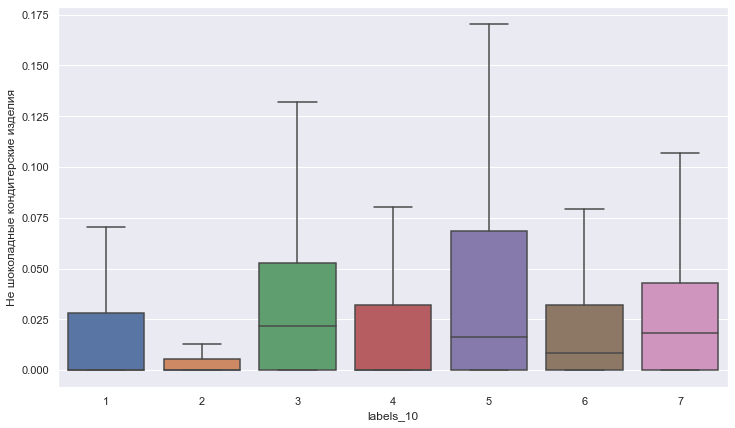

In [499]:
print("Не шоколадные кондитерские изделия")
sns.boxplot(x="labels_10", y="Не шоколадные кондитерские изделия", data=final_df_sample, showfliers = False)

Шоколадные кондитерские изделия


<AxesSubplot:xlabel='labels_10', ylabel='Шоколадные кондитерские изделия'>

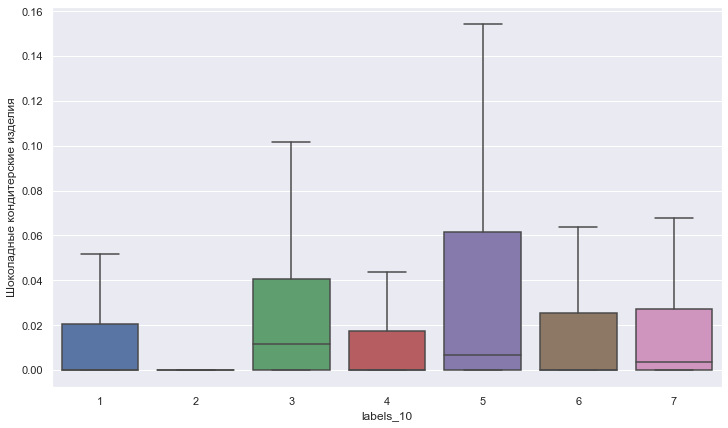

In [500]:
print("Шоколадные кондитерские изделия")
sns.boxplot(x="labels_10", y="Шоколадные кондитерские изделия", data=final_df_sample, showfliers = False)

Безалкогольные напитки


<AxesSubplot:xlabel='labels_10', ylabel='Безалкогольные напитки'>

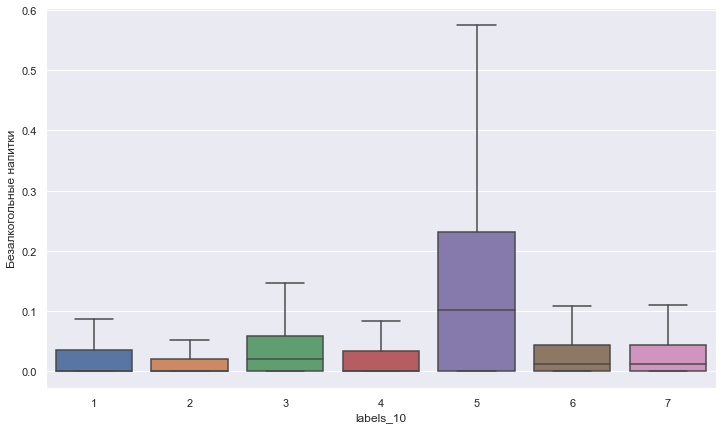

In [501]:
print("Безалкогольные напитки")
sns.boxplot(x="labels_10", y="Безалкогольные напитки", data=final_df_sample, showfliers = False)

Бакалея


<AxesSubplot:xlabel='labels_10', ylabel='Бакалея'>

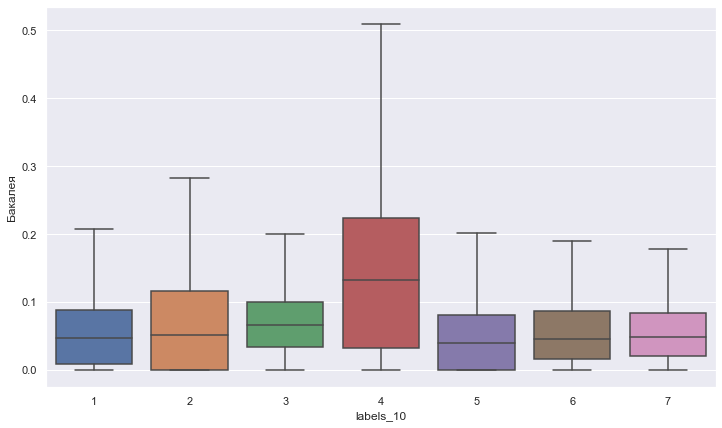

In [502]:
print("Бакалея")
sns.boxplot(x="labels_10", y="Бакалея", data=final_df_sample, showfliers = False)

П\ф и другие продукты глубокой заморзк


<AxesSubplot:xlabel='labels_10', ylabel='П\\ф и другие продукты глубокой заморзк'>

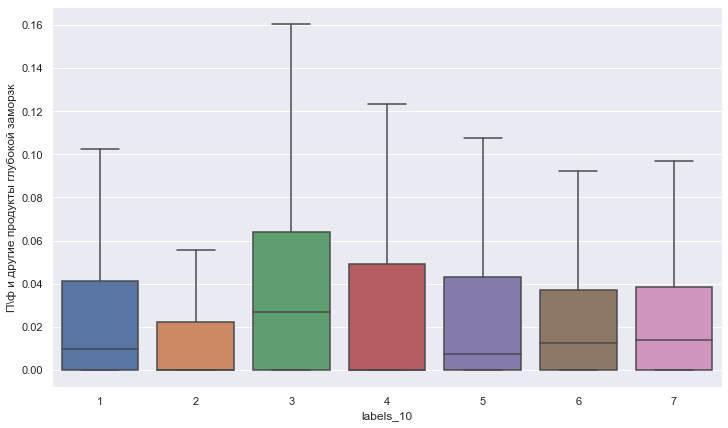

In [503]:
print("П\ф и другие продукты глубокой заморзк")
sns.boxplot(x="labels_10", y="П\ф и другие продукты глубокой заморзк", data=final_df_sample, showfliers = False)

Бытовая химия, хозяйственные товары


<AxesSubplot:xlabel='labels_10', ylabel='Бытовая химия, хозяйственные товары'>

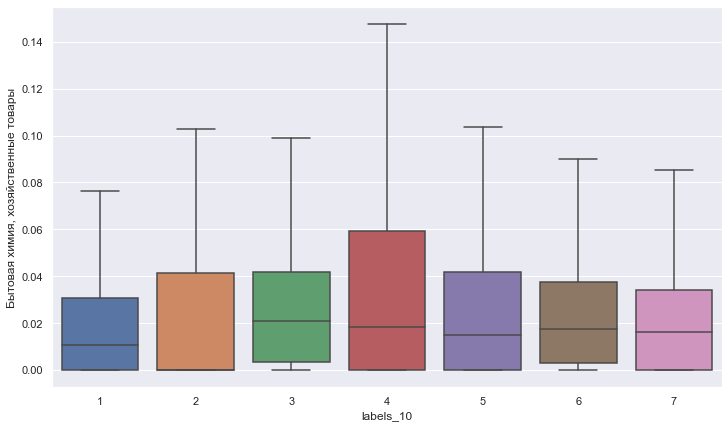

In [257]:
print("Бытовая химия, хозяйственные товары")
sns.boxplot(x="labels_10", y="Бытовая химия, хозяйственные товары", data=df_vis, showfliers = False)

Гигиенические средства


<AxesSubplot:xlabel='labels_10', ylabel='Гигиенические средства'>

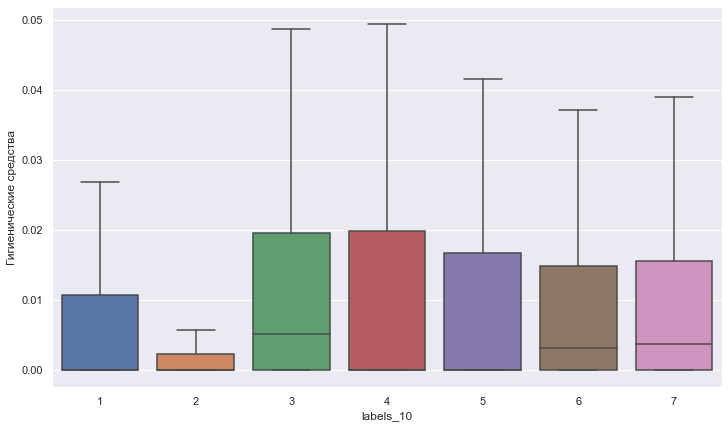

In [258]:
print("Гигиенические средства")
sns.boxplot(x="labels_10", y="Гигиенические средства", data=df_vis, showfliers = False)

Консервы


<AxesSubplot:xlabel='labels_10', ylabel='Консервы'>

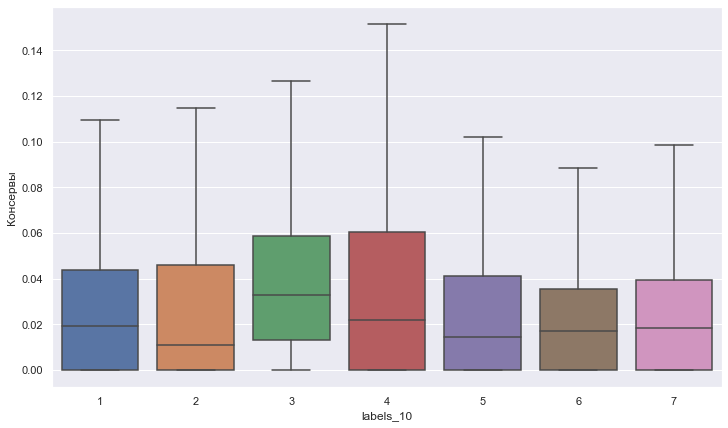

In [259]:
print("Консервы")
sns.boxplot(x="labels_10", y="Консервы", data=df_vis, showfliers = False)